# In silico identification of switching nodes (ISIS), by F. Mairet
## <I>Saccharomyces cerevisiae</I> under nitrogen limitation - Sampling

In [1]:
import cobra
import numpy as np
from pandas import DataFrame
import pandas as pd
model=cobra.io.read_sbml_model("yeastGEM.xml")

S=cobra.util.array.create_stoichiometric_matrix(model,array_type='dense') # stoichiometric matrix
nm=S.shape[0] # number of metabolites

### Computation of fluxes with pFBA

In [2]:
model_NH4=cobra.io.read_sbml_model("yeastGEM.xml")
medium = model_NH4.medium
medium["r_1992"] = 10.0 #oxygen
medium["r_1714"] = 10.0 #glucose
medium["r_1654"] = 1.0 #NH4
model_NH4.medium = medium
pfba_NH4 = cobra.flux_analysis.pfba(model_NH4)

model_Ala=cobra.io.read_sbml_model("yeastGEM.xml")
medium = model_Ala.medium
medium["r_1992"] = 10.0 #oxygen
medium["r_1714"] = 10.0 #glucose
medium["r_1654"] = 0 #Nh4
medium["r_1873"] = 1 #alanine
model_Ala.medium = medium
pfba_Ala = cobra.flux_analysis.pfba(model_Ala)

model_Gln=cobra.io.read_sbml_model("yeastGEM.xml")
medium = model_Gln.medium
medium["r_1992"] = 10.0 #oxygen
medium["r_1714"] = 10.0 #glucose
medium["r_1654"] = 0 #Nh4
medium["r_1873"] = 0 #alanine
medium["r_1891"] = 1 #glutamine
model_Gln.medium = medium
pfba_Gln = cobra.flux_analysis.pfba(model_Gln)

# Concatenation and normalization of fluxes
VV=(np.concatenate((np.array(pfba_NH4.fluxes)[np.newaxis,:],np.array(pfba_Ala.fluxes)[np.newaxis,:],np.array(pfba_Gln.fluxes)[np.newaxis,:]),axis=0)).T
VV=np.divide(VV,np.linalg.norm(VV,axis=0))

df1=DataFrame(VV,index=model.reactions,columns=['NH4','Ala','Gln'])
df1.to_excel('Scerevisiae_Flux.xlsx', sheet_name='sheet1', index=True)

### Flux sampling

In [3]:
from cobra.sampling import sample

#nr=S.shape[1]

ns=1000 # number of samples

solution_NH4=model_NH4.optimize()
model_NH4.reactions.get_by_id("r_2111").lower_bound=solution_NH4.objective_value#*0.99

sample_NH4 = sample(model_NH4, ns, processes=4)
sample_NH4.head()
sample_NH4.to_excel('Flux_sample_NH4.xlsx')

solution_Ala=model_Ala.optimize()
model_Ala.reactions.get_by_id("r_2111").lower_bound=solution_Ala.objective_value#*0.99
sample_Ala = sample(model_Ala, ns, processes=4)
sample_Ala.to_excel('Flux_sample_Ala.xlsx')

solution_Gln=model_Gln.optimize()
model_Gln.reactions.get_by_id("r_2111").lower_bound=solution_Gln.objective_value#*0.99
sample_Gln = sample(model_Gln, ns, processes=4)
sample_Gln.to_excel('Flux_sample_Gln.xlsx')

### Identification of switch nodes

#### NH4 vs Ala

In [5]:
# with pFBA
V=VV[:,[0,1]]

# loop on all the metabolites to compute their score
r=np.zeros(nm)
for i in range (0,nm):
    jj=S[i,:]!=0
    M=np.multiply(S[i,jj][np.newaxis,:].T, V[jj,:]) # compute M, removing the zero rows   
    u, s, vh = np.linalg.svd(M)
    if s[0]==0:
        r[i]=0
    else:
        r[i]=1-pow(s[0],2)/sum(pow(s,2))
        
# Print the results
ind=np.argsort(r)
for i in range (1,20):
   print(i,model.metabolites[ind[-i]].name,':',r[ind[-i]])

1 H+ [cell envelope] : 0.47519261532298485
2 H2O [cell envelope] : 0.4751926153203694
3 choline [cell envelope] : 0.47358272484756825
4 oleate [cell envelope] : 0.4664713574748377
5 D-xylulose 5-phosphate [cytoplasm] : 0.2576594670012605
6 keto-phenylpyruvate [cytoplasm] : 0.24997088183401306
7 L-phenylalanine [cytoplasm] : 0.24997088183401306
8 4-methyl-5-(2-phosphonooxyethyl)thiazole [cytoplasm] : 0.24997088183401295
9 gamma-aminobutyrate [cytoplasm] : 0.24997088183401284
10 L-tyrosine [cytoplasm] : 0.24997088183401284
11 3-(4-hydroxyphenyl)pyruvate [cytoplasm] : 0.24997088183401284
12 citrate [cytoplasm] : 0.24007904672468705
13 palmitoleate [cell envelope] : 0.19769320682159863
14 AMP [lipid particle] : 0.17928536103813408
15 diphosphate [lipid particle] : 0.17928536103813408
16 L-glutamate [cytoplasm] : 0.1743156224770701
17 2-oxoglutarate [cytoplasm] : 0.17431128424010545
18 H+ [extracellular] : 0.13069167250160918
19 ATP [lipid particle] : 0.1241454020941487


In [6]:
# Identification of switch nodes with Flux sampling
import random

# random index to create ns combinations 
ind2=list(range(0,ns))
random.seed(1)   
random.shuffle(ind2)

# loop on all the combinations
r2=np.zeros((nm,ns))

for k in range (0,ns):
    # Concatenation and normalization of fluxes
    V=(np.concatenate((np.array(sample_NH4.iloc[k])[np.newaxis,:],np.array(sample_Ala.iloc[ind2[k]])[np.newaxis,:]),axis=0)).T
    V=np.divide(V,np.linalg.norm(V,axis=0))

    # loop on all the metabolites to compute their score
    for i in range (0,nm):
        jj=S[i,:]!=0
        M=np.multiply(S[i,jj][np.newaxis,:].T, V[jj,:]) # compute M, removing the zero rows 
        u, s, vh = np.linalg.svd(M)   
        if s[0]==0:
            r2[i,k]=0
        else:
            r2[i,k]=1-pow(s[0],2)/sum(pow(s,2))
        
# Computation of the mean and standard deviation of the switching score for each metabolite
r_sample=np.mean(r2,axis=1)
sdr_sample=np.std(r2,axis=1)

# Export and print the results
df2=pd.concat([DataFrame(model.metabolites, columns=['Metabolite']), DataFrame(r, columns=['score with pFBA']), DataFrame(r_sample, columns=['score with Flux sampling']), DataFrame(sdr_sample, columns=['Standard deviation'])], axis = 1) 

print('metabolite : score with pFBA : score with flux sampling')
for i in range (1,nm):
    print(model.metabolites[ind[-i]].name,':',r[ind[-i]],':',r_sample[ind[-i]])

metabolite : score with pFBA : score with flux sampling
H+ [cell envelope] : 0.47519261532298485 : 0.10831912060836771
H2O [cell envelope] : 0.4751926153203694 : 0.01655780636744271
choline [cell envelope] : 0.47358272484756825 : 0.02229240825863074
oleate [cell envelope] : 0.4664713574748377 : 0.022242929819926174
D-xylulose 5-phosphate [cytoplasm] : 0.2576594670012605 : 0.051024112262304216
keto-phenylpyruvate [cytoplasm] : 0.24997088183401306 : 2.4136091485549293e-08
L-phenylalanine [cytoplasm] : 0.24997088183401306 : 5.007517839494824e-09
4-methyl-5-(2-phosphonooxyethyl)thiazole [cytoplasm] : 0.24997088183401295 : 1.8179393292727662e-07
gamma-aminobutyrate [cytoplasm] : 0.24997088183401284 : 0.029371803902478753
L-tyrosine [cytoplasm] : 0.24997088183401284 : 0.03561964942947123
3-(4-hydroxyphenyl)pyruvate [cytoplasm] : 0.24997088183401284 : 2.0601341378656546e-07
citrate [cytoplasm] : 0.24007904672468705 : 0.03590177523358069
palmitoleate [cell envelope] : 0.19769320682159863 : 0.0

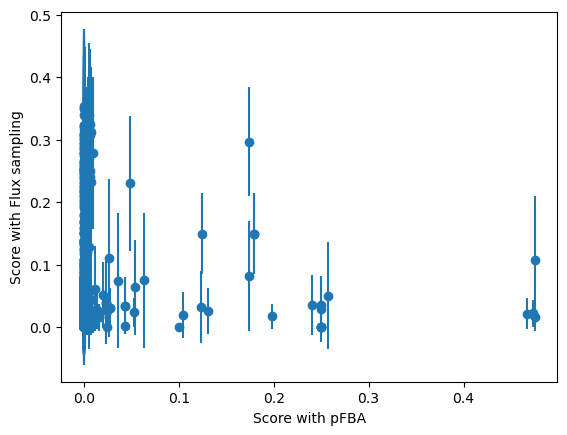

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.errorbar(r,r_sample,yerr=sdr_sample,fmt='o')
plt.xlabel('Score with pFBA')
plt.ylabel('Score with Flux sampling')
plt.show()

In [8]:
from scipy import stats

res = stats.spearmanr(r,r_sample)
res

SignificanceResult(statistic=0.2791442613896185, pvalue=2.933236727215068e-50)

#### NH4 vs Gln

In [9]:
# Identification of switch nodes with pFBA
V=VV[:,[0,2]]

# loop on all the metabolites to compute their score
r=np.zeros(nm)
for i in range (0,nm):
    jj=S[i,:]!=0
    M=np.multiply(S[i,jj][np.newaxis,:].T, V[jj,:]) # compute M, removing the zero rows 
    u, s, vh = np.linalg.svd(M)
    if s[0]==0:
        r[i]=0
    else:
        r[i]=1-pow(s[0],2)/sum(pow(s,2))
        
# Print the results
ind=np.argsort(r)
for i in range (1,20):
   print(i,model.metabolites[ind[-i]].name,':',r[ind[-i]])

1 phosphatidylcholine (1-16:1, 2-16:1) [mitochondrial membrane] : 0.4570220976900241
2 1-acylglycerophosphocholine (16:1) [mitochondrial membrane] : 0.3726627778472391
3 L-aspartate [cytoplasm] : 0.35746130201798443
4 D-erythrose 4-phosphate [cytoplasm] : 0.35134218412694773
5 H+ [extracellular] : 0.3159615471495051
6 phosphatidylethanolamine (1-18:0, 2-16:1) [endoplasmic reticulum membrane] : 0.27776172084422557
7 phosphatidyl-L-serine (1-18:0, 2-16:1) [endoplasmic reticulum membrane] : 0.24767479830828365
8 phosphatidylethanolamine (1-16:1, 2-16:1) [endoplasmic reticulum membrane] : 0.24649874064072053
9 phosphatidyl-L-serine (1-16:0, 2-16:1) [endoplasmic reticulum membrane] : 0.2450844037926191
10 phosphatidylethanolamine (1-16:0, 2-16:1) [endoplasmic reticulum membrane] : 0.24508440379128227
11 7-phospho-2-dehydro-3-deoxy-D-arabino-heptonic acid [cytoplasm] : 0.24487283384555925
12 4-methyl-5-(2-phosphonooxyethyl)thiazole [cytoplasm] : 0.2448728338455588
13 L-isoleucine [cytoplasm]

In [10]:
# Identification of switch nodes with Flux sampling

# loop on all the combinations
r2=np.zeros((nm,ns))

for k in range (0,ns):
    # Concatenation and normalization of fluxes
    V=(np.concatenate((np.array(sample_NH4.iloc[k])[np.newaxis,:],np.array(sample_Gln.iloc[ind2[k]])[np.newaxis,:]),axis=0)).T
    V=np.divide(V,np.linalg.norm(V,axis=0))

    # loop on all the metabolites to compute their score
    for i in range (0,nm):
        jj=S[i,:]!=0
        M=np.multiply(S[i,jj][np.newaxis,:].T, V[jj,:]) # compute M, removing the zero rows 
        u, s, vh = np.linalg.svd(M)  
        if s[0]==0:
            r2[i,k]=0
        else:
            r2[i,k]=1-pow(s[0],2)/sum(pow(s,2))
        
# Computation of the mean and standard deviation of the switching score for each metabolite
r_sample=np.mean(r2,axis=1)
sdr_sample=np.std(r2,axis=1)

# Export and print the results
df3=pd.concat([DataFrame(model.metabolites, columns=['Metabolite']), DataFrame(r, columns=['score with pFBA']), DataFrame(r_sample, columns=['score with Flux sampling']), DataFrame(sdr_sample, columns=['Standard deviation'])], axis = 1) 

print('metabolite : score with pFBA : score with flux sampling')
for i in range (1,nm):
    print(model.metabolites[ind[-i]].name,':',r[ind[-i]],':',r_sample[ind[-i]])

metabolite : score with pFBA : score with flux sampling
phosphatidylcholine (1-16:1, 2-16:1) [mitochondrial membrane] : 0.4570220976900241 : 0.293370233275368
1-acylglycerophosphocholine (16:1) [mitochondrial membrane] : 0.3726627778472391 : 0.3097525149708846
L-aspartate [cytoplasm] : 0.35746130201798443 : 1.123125442159867e-06
D-erythrose 4-phosphate [cytoplasm] : 0.35134218412694773 : 0.033850946394763354
H+ [extracellular] : 0.3159615471495051 : 0.08703051400330644
phosphatidylethanolamine (1-18:0, 2-16:1) [endoplasmic reticulum membrane] : 0.27776172084422557 : 0.22869419424186982
phosphatidyl-L-serine (1-18:0, 2-16:1) [endoplasmic reticulum membrane] : 0.24767479830828365 : 0.007580885144575801
phosphatidylethanolamine (1-16:1, 2-16:1) [endoplasmic reticulum membrane] : 0.24649874064072053 : 0.32512613756714287
phosphatidyl-L-serine (1-16:0, 2-16:1) [endoplasmic reticulum membrane] : 0.2450844037926191 : 0.012864445953264756
phosphatidylethanolamine (1-16:0, 2-16:1) [endoplasmic 

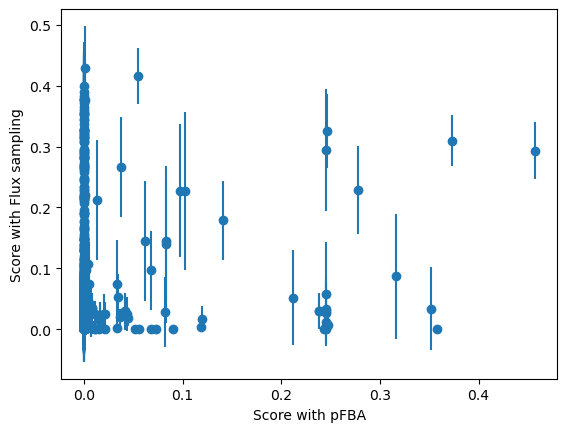

In [11]:
fig, ax = plt.subplots()
plt.errorbar(r,r_sample,yerr=sdr_sample,fmt='o')
plt.xlabel('Score with pFBA')
plt.ylabel('Score with Flux sampling')
plt.show()

In [12]:
res = stats.spearmanr(r,r_sample)
res

SignificanceResult(statistic=0.2584850524867519, pvalue=4.212366623757672e-43)

#### Ala vs Gln

In [13]:
# Identification of switch nodes with pFBA
V=VV[:,[1,2]]

# loop on all the metabolites to compute their score
r=np.zeros(nm)
for i in range (0,nm):
    jj=S[i,:]!=0
    M=np.multiply(S[i,jj][np.newaxis,:].T, V[jj,:]) # compute M, removing the zero rows 
    u, s, vh = np.linalg.svd(M)
    if s[0]==0:
        r[i]=0
    else:
        r[i]=1-pow(s[0],2)/sum(pow(s,2))
        
# Print the results     
ind=np.argsort(r)
for i in range (1,25):
   print(i,model.metabolites[ind[-i]].name,':',r[ind[-i]])

1 L-glutamate [cytoplasm] : 0.3818645056097838
2 L-aspartate [cytoplasm] : 0.3573038192811384
3 2-oxoglutarate [cytoplasm] : 0.3453352008432893
4 phosphatidyl-L-serine (1-16:0, 2-16:1) [endoplasmic reticulum membrane] : 0.2499033932934639
5 phosphatidylethanolamine (1-16:0, 2-16:1) [endoplasmic reticulum membrane] : 0.24990339329266564
6 phosphatidylethanolamine (1-16:1, 2-16:1) [endoplasmic reticulum membrane] : 0.24421403882192394
7 phosphatidyl-L-serine (1-18:0, 2-18:1) [endoplasmic reticulum membrane] : 0.24409647530022227
8 phosphatidylethanolamine (1-18:0, 2-18:1) [endoplasmic reticulum membrane] : 0.24409647529984402
9 phosphatidyl-L-serine (1-18:0, 2-16:1) [endoplasmic reticulum membrane] : 0.24409647514332222
10 phosphatidylethanolamine (1-18:0, 2-16:1) [endoplasmic reticulum membrane] : 0.24409647511918908
11 D-erythrose 4-phosphate [cytoplasm] : 0.24409647498479548
12 7-phospho-2-dehydro-3-deoxy-D-arabino-heptonic acid [cytoplasm] : 0.24409647498479525
13 L-phenylalanine [cy

In [14]:
# Identification of switch nodes with Flux sampling
r2=np.zeros((nm,ns))

# loop on all the combinations
for k in range (0,ns):
    # Concatenation and normalization of fluxes
    V=(np.concatenate((np.array(sample_Ala.iloc[k])[np.newaxis,:],np.array(sample_Gln.iloc[ind2[k]])[np.newaxis,:]),axis=0)).T
    V=np.divide(V,np.linalg.norm(V,axis=0))

    # loop on all the metabolites to compute their score
    for i in range (0,nm):
        jj=S[i,:]!=0
        M=np.multiply(S[i,jj][np.newaxis,:].T, V[jj,:]) # compute M, removing the zero rows 
        u, s, vh = np.linalg.svd(M)   
        if s[0]==0:
            r2[i,k]=0
        else:
            r2[i,k]=1-pow(s[0],2)/sum(pow(s,2))
        
# Computation of the mean and standard deviation of the switching score for each metabolite
r_sample=np.mean(r2,axis=1)
sdr_sample=np.std(r2,axis=1)

# Export and print the results
df4=pd.concat([DataFrame(model.metabolites, columns=['Metabolite']), DataFrame(r, columns=['score with pFBA']), DataFrame(r_sample, columns=['score with Flux sampling']), DataFrame(sdr_sample, columns=['Standard deviation'])], axis = 1) 
 
with pd.ExcelWriter("Scerevisiae_Metabolite_sampling.xlsx") as writer:
    df2.to_excel(writer, sheet_name="NH4_vs_Ala", index=False)
    df3.to_excel(writer, sheet_name="NH4_vs_Gln", index=False)
    df4.to_excel(writer, sheet_name="Ala_vs_Gln", index=False)
    
print('metabolite : score with pFBA : score with flux sampling')
for i in range (1,nm):
    print(model.metabolites[ind[-i]].name,':',r[ind[-i]],':',r_sample[ind[-i]])

metabolite : score with pFBA : score with flux sampling
L-glutamate [cytoplasm] : 0.3818645056097838 : 0.2053884419193813
L-aspartate [cytoplasm] : 0.3573038192811384 : 3.187785567132506e-07
2-oxoglutarate [cytoplasm] : 0.3453352008432893 : 0.29698641095234196
phosphatidyl-L-serine (1-16:0, 2-16:1) [endoplasmic reticulum membrane] : 0.2499033932934639 : 0.01856135429005684
phosphatidylethanolamine (1-16:0, 2-16:1) [endoplasmic reticulum membrane] : 0.24990339329266564 : 0.23808194678656847
phosphatidylethanolamine (1-16:1, 2-16:1) [endoplasmic reticulum membrane] : 0.24421403882192394 : 0.18984185429064085
phosphatidyl-L-serine (1-18:0, 2-18:1) [endoplasmic reticulum membrane] : 0.24409647530022227 : 0.023499031516778977
phosphatidylethanolamine (1-18:0, 2-18:1) [endoplasmic reticulum membrane] : 0.24409647529984402 : 0.16607611192449884
phosphatidyl-L-serine (1-18:0, 2-16:1) [endoplasmic reticulum membrane] : 0.24409647514332222 : 0.022863794462387305
phosphatidylethanolamine (1-18:0,

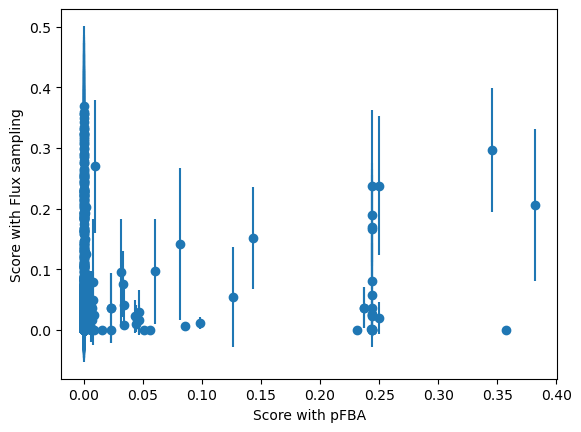

In [15]:
fig, ax = plt.subplots()
plt.errorbar(r,r_sample,yerr=sdr_sample,fmt='o')
plt.xlabel('Score with pFBA')
plt.ylabel('Score with Flux sampling')
plt.show()

In [16]:
res = stats.spearmanr(r,r_sample)
res

SignificanceResult(statistic=0.262334136307571, pvalue=2.1809766907386514e-44)